## **This is the second part of *Facial Expression Recognition Challenge* from [Kaggle](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).**

#### In the first part I transformed CSV data into two tensors (X, y) for the sake of convenience and uploaded them into my google drive. <br> In this part I'll create a small CNN, train in on clound GPU and try to achieve 80% accuracy.

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from tqdm import tqdm
from sklearn.utils import shuffle

sns.set_style('whitegrid')

In [189]:
from google.colab import drive
drive.mount("/content/drive")

X = torch.load('/content/drive/My Drive/Colab Notebooks/Facial expression/X.pt') # 28709 images (48,48) flattened into 2304 with 0-255 values
y = torch.load('/content/drive/My Drive/Colab Notebooks/Facial expression/y.pt') # Integer values with seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
print('X size: ', X.size())
print('y size: ', y.size())

X size:  torch.Size([28709, 2304])
y size:  torch.Size([28709])


In [191]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## **Preprocessing and train test split**

In [192]:
# Normalizing X
X = X / 255.
X = X

# Splitilng into train and test sets and centering the data
X_train = X[:25000]
X_MEAN = 0.449 # Mean of ImageNet means
X_train = X_train.numpy()
X_train = X_train - X_MEAN
X_train = torch.tensor(X_train).float()
y_train = y[:25000].float()

X_test = X[25000:].numpy()
X_test = X_test - X_MEAN
X_test = torch.tensor(X_test).float()
y_test = y[25000:].float()

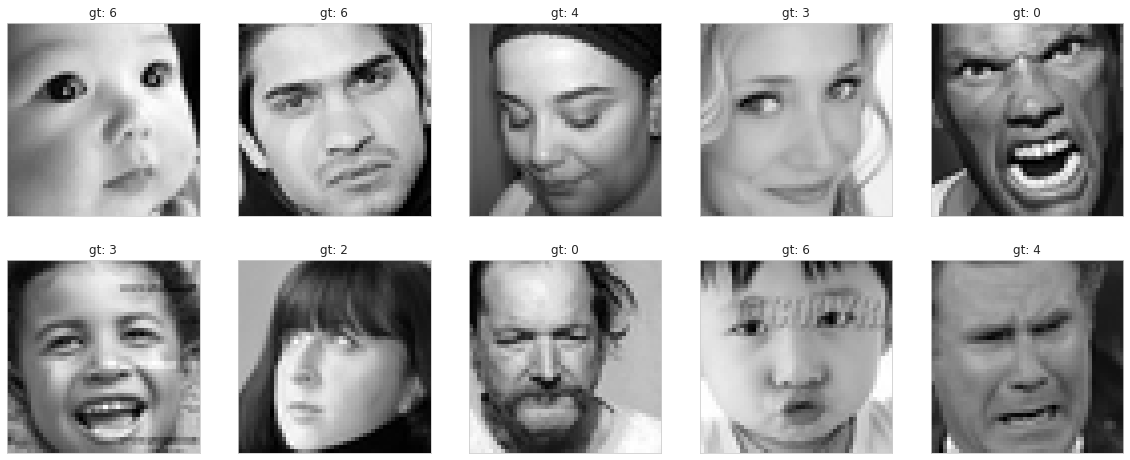

In [193]:
def checking_data(X, y, with_predictions=False, net=None):
  """"
  Drawing random images from given data, printing groud truth in the title.
  If with_predicions is True printing prediction for given X in the title as well.
  
  Parameters:
    X - type[tensor or np.array], features 
    y - type[tensor or np.array], labels
    with_predictions - type[bool], check predictions or not
    net - Neural network  
  """
  plt.figure(figsize=(20,8))
  a = np.random.randint(0, len(y), size=10)
  
  for i,k in enumerate(a):
    X_inner = X[k]
    label = y[k]

    if with_predictions:
      net.eval()
      with torch.no_grad():
        output = net(X_inner.view(1, 1, 48, 48).to(device))
        pred = torch.argmax(output)
        title = 'gt: ' + str(int(label)) + ' Pred: ' + str(int(pred))
      
    else:
      title = 'gt: ' + str(int(label))

    plt.subplot(2, 5, i+1)
    plt.imshow(X_inner.view(48,48), cmap='gray')
    plt.title(title, fontsize=12)
    plt.xticks([])
    plt.yticks([])

  plt.show()

checking_data(X_train, y_train)

#### First of all, I need to check if data is balanced

In [194]:
a = pd.Series(y_train)
print('Count of labels in train data:\n')
a.value_counts(normalize=False)

Count of labels in train data:



3.0    6297
6.0    4321
4.0    4209
2.0    3609
0.0    3454
5.0    2721
1.0     389
dtype: int64

In [195]:
a = pd.Series(y_test)
print('Count of labels in test data:\n')
a.value_counts(normalize=False)

Count of labels in test data:



3.0    918
6.0    644
4.0    621
0.0    541
2.0    488
5.0    450
1.0     47
dtype: int64

#### Since data isn't perfectly balanced, I'll make function to grab balanced samples from it.

In [196]:
def sample_fn(X, y, size=200):
  """
  Returning sample of data with balanced classes
  Parameters:
    X - type[tensor or np.array], features 
    y - type[tensor or np.array], labels
    size - elements in each classes
  """
  # Combining tensors
  X_array = X.numpy()
  y_array = y.numpy()

  ALL = []

  for i in range(len(X_array)):
    new_value = [X_array[i].reshape(-1, 2304), int(y_array[i])]
    ALL.append(new_value)

  ALL = np.array(ALL)

  # Sampling data
  count = {0:0,
         1:0,
         2:0,
         3:0,
         4:0,
         5:0,
         6:0}

  sample_data = []

  for i in range(len(ALL)):
    label = int(ALL[i][1])

    if count[label]==size:
      continue
    else:
      sample_data.append(ALL[i])
      count[label] += 1

  sample_data = np.array(sample_data)

  return sample_data

sample_data = sample_fn(X_train, y_train, size=2700)

In [197]:
# Train sample
X_train_sample = [i[:][0] for i in sample_data]
X_train_sample = np.array(X_train_sample).reshape(-1, 2304)
X_train_sample = torch.tensor(X_train_sample).float()

y_train_sample = [i[:][1] for i in sample_data]
y_train_sample = np.array(y_train_sample)
y_train_sample = torch.tensor(y_train_sample).float()

In [198]:
# Small test set for quick check
small_test = sample_fn(X_test, y_test, size=150)

X_test_sample = [i[:][0] for i in small_test]
X_test_sample = np.array(X_test_sample).reshape(-1, 2304)
X_test_sample = torch.tensor(X_test_sample).float()

y_test_sample = [i[:][1] for i in small_test]
y_test_sample = np.array(y_test_sample)
y_test_sample = torch.tensor(y_test_sample).float()

In [199]:
a = pd.Series(y_train_sample.numpy())
print('Count of labels in sample train data:\n')
a.value_counts()

Count of labels in sample train data:



5.0    2700
3.0    2700
6.0    2700
4.0    2700
2.0    2700
0.0    2700
1.0     389
dtype: int64

In [200]:
a = pd.Series(y_test_sample.numpy())
print('Count of labels in sample test data:\n')
a.value_counts()

Count of labels in sample test data:



5.0    150
6.0    150
4.0    150
3.0    150
2.0    150
0.0    150
1.0     47
dtype: int64

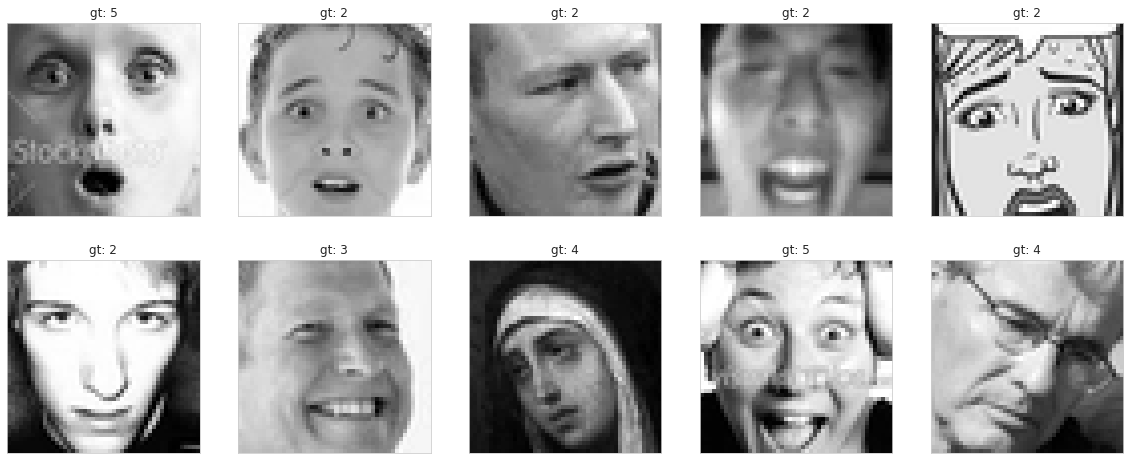

In [219]:
# Checking if features and labels didn't mess with
checking_data(X_train_sample, y_train_sample)

### **Net architecture**

Due to my low  computational power I can't train very deep networks(and I didn't want to use transfer learning), so I had to find some compromise between depth and performance.<br>I decided to use my modification of [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf), with less neurons, keeping overall architectural patterns.

In [209]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2)
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(128, 84, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

    # To flatten last Conv layer I am using this little trick
    # All credits to this guy https://pythonprogramming.net/
    self._to_linera = None
    x = torch.randn(48,48).view(-1, 1, 48, 48)
    x = self.convs(x)

    self.fc1 = nn.Linear(self._to_linera, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 7)

  def convs(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxpool1(x)
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.maxpool2(x)

    if self._to_linera is None:
      self._to_linera = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linera)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim=1)

net = Net().to(device)

## **Model training**

In [210]:
def calculating_loss(net, X, y, batch_size, loss_fn, optimizer, train_model=False):
  """
  Calculating loss for given parameters.
  Has option to train model(if train_model=True)
  """
  X, y = shuffle(X, y)

  for k in range(0, len(y), BATCH_SIZE):
    X_batch = X[k:k+BATCH_SIZE].to(device)
    y_batch = y[k:k+BATCH_SIZE].to(device)
    
    if train_model:
      net.train()
      net.zero_grad()
      outputs = net(X_batch.view(-1, 1, 48, 48))
      loss = loss_fn(outputs, y_batch.long())
      loss.backward()
      optimizer.step()    
    else:
      net.eval()
      with torch.no_grad():
        outputs = net(X_batch.view(-1, 1, 48, 48))
        loss = loss_fn(outputs, y_batch.long())

  loss = float(loss)
  loss = np.round(loss, 2)

  return loss

def calculating_acc(net, X, y):
  """
  Calculating accuracy for given network and data.
  """
  correct = 0
  total = 0

  net.eval()
  with torch.no_grad():
    for i in range(len(y)):
      label = int(y[i])
      X_inner = X[i].to(device)
      output = net(X_inner.view(1, 1, 48, 48))
      pred = int(torch.argmax(output))
      
      if pred==label:
        correct += 1

      total += 1

  acc = correct / total * 100
  acc = np.round(acc, 2)

  return acc

In [211]:
EPOCHS = np.arange(50)
BATCH_SIZE = 32
LR = 0.001
WD = 0.003
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr =LR, weight_decay=WD)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)

train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []

for epoch in tqdm(EPOCHS):
  # Training model and calculating train loss
  train_loss = calculating_loss(net, X_train_sample, y_train_sample, BATCH_SIZE, loss_fn, optimizer, train_model=True)
  train_loss_array.append(train_loss)
  
  # Calculating test loss
  test_loss = calculating_loss(net, X_test_sample, y_test_sample, BATCH_SIZE, loss_fn, optimizer, train_model=False)
  test_loss_array.append(test_loss)

  # Calcualting train and test accuracies
  train_acc = calculating_acc(net, X_train_sample, y_train_sample)
  train_acc_array.append(train_acc)

  test_acc = calculating_acc(net, X_test_sample, y_test_sample)
  test_acc_array.append(test_acc)
  
  scheduler.step()


100%|██████████| 50/50 [13:41<00:00, 16.43s/it]


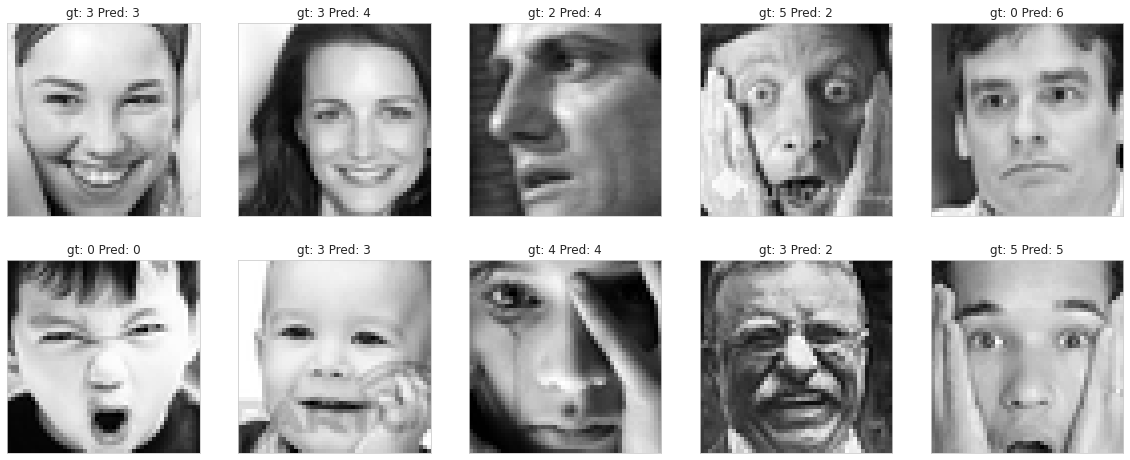

gt:  3
tensor([-4.2337, -7.5092, -3.0371, -0.4000, -2.9181, -6.0617, -1.5592],
       device='cuda:0', grad_fn=<SelectBackward>)
Pred:  3
---------------------
gt:  3
tensor([-2.5671, -4.6385, -2.3737, -0.4051, -3.6513, -4.3474, -2.1662],
       device='cuda:0', grad_fn=<SelectBackward>)
Pred:  3
---------------------
gt:  5
tensor([-2.3089, -6.5533, -1.2941, -5.0479, -5.3991, -0.4973, -5.1260],
       device='cuda:0', grad_fn=<SelectBackward>)
Pred:  5
---------------------
gt:  2
tensor([-2.1000, -8.0669, -3.0989, -2.8493, -2.0609, -4.0119, -0.4639],
       device='cuda:0', grad_fn=<SelectBackward>)
Pred:  6
---------------------
gt:  2
tensor([-2.0343, -3.4687, -2.4461, -1.0896, -1.8454, -4.1413, -1.4220],
       device='cuda:0', grad_fn=<SelectBackward>)
Pred:  3
---------------------


In [216]:
checking_data(X_test_sample, y_test_sample, with_predictions=True, net=net)

# Cheking if network outputs same value(significant problem for my netwokrs)
r = np.random.randint(0, len(y_test), size=5)
for k in r:
  print('gt: ', int(y_test[k]))
  output = net(X_test[k].view(1, 1, 48, 48).to(device))
  print(output[0])
  print('Pred: ', int(torch.argmax(output)))
  print('---------------------')

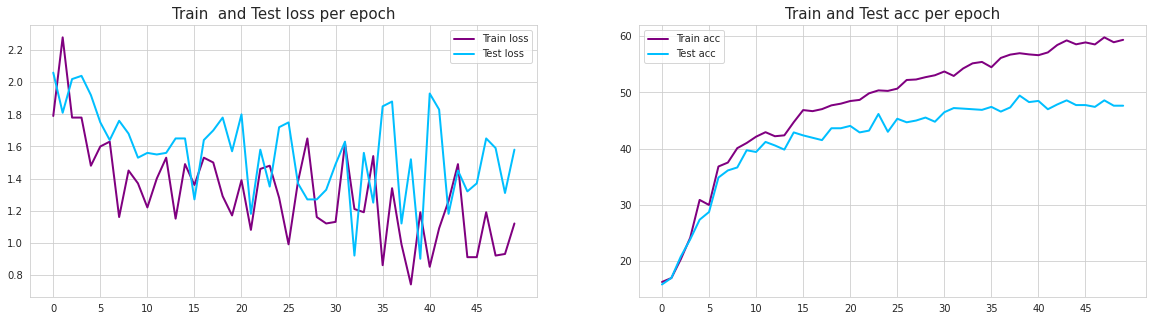

In [213]:
plt.figure(figsize=(20, 5))


plt.subplot(1, 2, 1)
sns.lineplot(x=EPOCHS, y=train_loss_array, color='purple', linewidth=2, label='Train loss')
sns.lineplot(x=EPOCHS, y=test_loss_array, color='deepskyblue', linewidth=2, label='Test loss')
plt.xticks(np.arange(0, len(train_loss_array), 5))
plt.legend()
plt.title('Train  and Test loss per epoch', fontsize=15)

plt.subplot(1, 2, 2)
sns.lineplot(x=EPOCHS, y=train_acc_array, color='purple', linewidth=2, label='Train acc')
sns.lineplot(x=EPOCHS, y=test_acc_array, color='deepskyblue', linewidth=2, label='Test acc')
plt.xticks(np.arange(0, len(train_acc_array), 5))
plt.legend()
plt.title('Train and Test acc per epoch', fontsize=15)


plt.show()

In [214]:
state = False
if state:
  torch.save(net.state_dict(), '/content/drive/My Drive/Colab Notebooks/Facial expression/MiniAlexNet(50.44_acc)_weights')
  torch.save(net, '/content/drive/My Drive/Colab Notebooks/Facial expression/FullModel(50.44)')

In [215]:
print('Full test set accuracy:')
print(calculating_acc(net, X_test, y_test), '%')

Full test set accuracy:
50.74 %


#### Summary
From the right graph above it is obvious that my model is overfitting train set. This happpened befor, but then I add L2 Regularization with lambda=0.003 and test accuracy raised from ~30 to ~50. Also, I changed sample train set(from 2000 elements of each class to 2700), this helped a little.<br>
I'll keep working on this project, in particular, I want to get more data(just copying classes with less data to gain much bigger dataset), try adjusting regularization, try dropout.
After all, I can change architecture completely and try different loss functions and optimizers.

If you have any suggestions, feel free to contact me.<br>
My E-mail: gevorghovhannisyan13@gmail.com.